In [57]:
import numpy as np
import text_functions as tf
import nltk
import matplotlib.pyplot as plt
import matplotlib

In [58]:
def word_count(data_file_name):
    amount_dictionary = {}
    text_file = open(data_file_name, "r")
    for line in text_file:
        if line != "\n":
            words = line.split()
            for word in words:
                if amount_dictionary.get(word) is None:
                    amount_dictionary[word] = 1
                else:
                    amount_dictionary[word] += 1
    text_file.close()

    return amount_dictionary

def assign_random_vectors(data_file_name, dimension, ones_number, threshold):
    dictionary = {}
    amount_dictionary = word_count(data_file_name)
    text_file = open(data_file_name, "r")
    for line in text_file: #read line in the file
        words = line.split() # extract words from the line
        for word in words:  # for each word
            if dictionary.get(word) is None: # If the word was not yed added to the vocabulary
                if amount_dictionary[word] < threshold:
                    dictionary[word] = tf.get_random_word_vector(dimension, ones_number) # assign a  
                else:
                    dictionary[word] = np.zeros(dimension) # frequent words are assigned with empty vectors. In a way they will not contribute to the word embedding

    text_file.close()
    return dictionary, amount_dictionary

def find_synonyms(test_name, lemmatizer, dimension):
    word_space = {} #embedings
    number_of_tests = 0
    text_file = open(test_name, "r") #open TOEFL tasks
    for line in text_file:
            words = line.split()
            words = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(word, 'v'), 'n'), 'a') for word in
                    words] # lemmatize words in the current test
            word_space[words[0]] = np.zeros(dimension)
            word_space[words[1]] = np.zeros(dimension)
            word_space[words[2]] = np.zeros(dimension)
            word_space[words[3]] = np.zeros(dimension)
            word_space[words[4]] = np.zeros(dimension)
            number_of_tests += 1
    text_file.close()
    return word_space, number_of_tests

def create_embeddings(data_file_name, synonyms, words_dic, window_size):
    text_file = open(data_file_name, "r")
    lines = [[] for _ in range(2 * window_size)] # neighboring lines
    i = window_size
    while i < 2 * window_size:
            line = "\n"
            while line == "\n":
                line = text_file.readline()
            lines[i] = line.split()
            i += 1
    line = text_file.readline()
    while line != "":
        if line != "\n":
            lines.append(line.split())
            words = [item for sublist in lines for item in sublist]
            start_index = sum(len(line) for line in lines[:window_size])
            length = len(lines[window_size])
            i = 0
            while i < length:
                if not (synonyms.get(words[start_index+i]) is None):
                    k = 1
                    
                    while (i - k >= 0) and (k <= window_size): #process left neighbors of the focus word
                        synonyms[words[start_index + i]] = np.add(synonyms[words[start_index + i]], np.roll(words_dic[words[(start_index + i) - k]], -k)) # The roll indicates the ammount of steps away from the focus word
                        k += 1

                    k = 1
                    while (i + k < length) and (k <= window_size): #process right neighbors of the focus word
                        synonyms[words[start_index + i]] = np.add(synonyms[words[start_index + i]], np.roll(words_dic[words[start_index + i + k]], k)) #update word embedding
                        k += 1

                i += 1
            lines.pop(0)
        line = text_file.readline()
    return synonyms

def predict(test_name, lemmatizer, synonyms, amount_dictionary, dimension, zero_vector, number_of_tests):
    i = 0
    text_file = open(test_name, 'r')
    right_answers = 0.0 # variable for correct answers
    number_skipped_tests = 0.0 # some tests could be skipped if there are no corresponding words in the vocabulary extracted from the training corpus
    x = 0
    while i < number_of_tests:
            line = text_file.readline() #read line in the file
            words = line.split()  # extract words from the line
            words = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(word, 'v'), 'n'), 'a') for word in
                    words]  # lemmatize words in the current test
            try:
                if not(amount_dictionary.get(words[0]) is None): # check if there word in the corpus for the query word
                    k = 1
                    while k < 5:
                        # if amount_dictionary.get(words[k]) is None:
                        #     word_space[words[k]] = np.random.randn(dimension)
                        if np.array_equal(synonyms[words[k]], zero_vector): # if no representation was learnt assign a random vector
                            synonyms[words[k]] = np.random.randn(dimension)
                        k += 1
                    right_answers += tf.get_answer_mod([synonyms[words[0]],synonyms[words[1]],synonyms[words[2]],
                                synonyms[words[3]],synonyms[words[4]]]) #check if word is predicted right
            except KeyError: # if there is no representation for the query vector than skip
                number_skipped_tests += 1
                print("skipped test: " + str(i) + "; Line: " + str(words))
            except IndexError as e:
                print(e)
                print(f"Test {i} is out of range")
                print(f"On line {line}")
                break
            i += 1
    text_file.close()
    return 100 * right_answers / number_of_tests

In [59]:
# Base stuff

def run_tests(threshold, dimensions, ones_number, window_size, number_of_tests):
    lemmatizer = nltk.WordNetLemmatizer()  # create an instance of lemmatizer
    test_name = "new_toefl.txt" # file with TOEFL dataset
    data_file_name = "lemmatized.text" # file with the text corpus

    dimension_test_results = {}
    for dimension in dimensions:
        dimension_test_results[dimension] = []

    for i in range(number_of_tests):
        print(f"######################## Test {i + 1} ########################")
        for dimension in dimensions:
            zero_vector = np.zeros(dimension)
            random_vector_dic, amount_dic = assign_random_vectors(data_file_name, dimension, ones_number, threshold)
            synonyms, number_of_tests = find_synonyms(test_name, lemmatizer, dimension)
            processed_text = create_embeddings(data_file_name, synonyms, random_vector_dic, window_size)
            accuracy = predict(test_name, lemmatizer, processed_text, amount_dic, dimension, zero_vector, number_of_tests)

            print(f"Accuracy for dimension {dimension} is {accuracy}%")

            dimension_test_results[dimension].append(accuracy)

    return dimension_test_results

def plot_results(results):
    for result in list(results.keys()):
        results[result] = np.array(results[result])

    points = len(next(iter(results.values())))
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, points))
    color_index = 0
    for dimension in results.keys():
        for simulation in results[dimension]:
            plt.scatter(dimension, simulation, color=colors[color_index])
            color_index += 1
        color_index = 0
    plt.title('Dimensionality vs Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Dimensions')
    plt.ylim(0, 100)
    plt.show()



######################## Test 1 ########################
Accuracy for dimension 100 is 53.75%
Accuracy for dimension 1000 is 71.25%
Accuracy for dimension 4000 is 67.5%
Accuracy for dimension 10000 is 76.25%
######################## Test 2 ########################
Accuracy for dimension 100 is 62.5%
Accuracy for dimension 1000 is 68.75%
Accuracy for dimension 4000 is 75.0%
Accuracy for dimension 10000 is 71.25%
######################## Test 3 ########################
Accuracy for dimension 100 is 52.5%
Accuracy for dimension 1000 is 67.5%
Accuracy for dimension 4000 is 67.5%
Accuracy for dimension 10000 is 72.5%
######################## Test 4 ########################
Accuracy for dimension 100 is 58.75%
Accuracy for dimension 1000 is 68.75%
Accuracy for dimension 4000 is 70.0%
Accuracy for dimension 10000 is 76.25%
######################## Test 5 ########################
Accuracy for dimension 100 is 55.0%
Accuracy for dimension 1000 is 57.5%
Accuracy for dimension 4000 is 73.75%
Accu

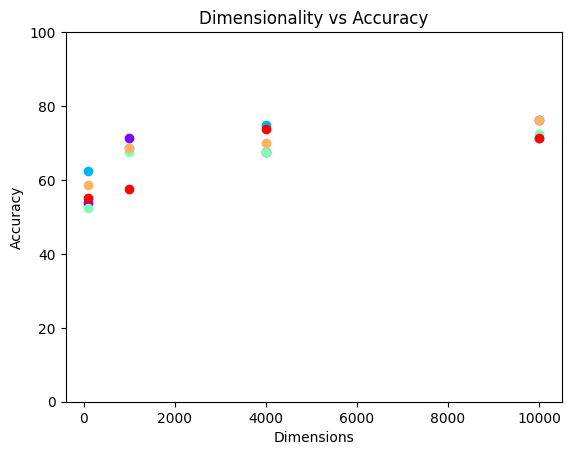

In [60]:
threshold = 15000 # Frequency threshold in the corpus ??
dimensions = [100, 1000, 4000, 10000] # Dimensionality for high-dimensional vectors
test_number = 5 # number of tests to run

ones_number = 2 # number of nonzero elements in randomly generated high-dimensional vectors
window_size = 2 #number of neighboring words to consider both back and forth. In other words number of words before/after current word

# Run tests
results = run_tests(threshold, dimensions, ones_number, window_size, test_number)
plot_results(results)

# Random indexing with permutations

## Report the accuracy on TOEFL for all simulations
See the plot and the specified values above it.

## The current code works adequately only when size of window is 2. What should be changed in order to overcome this issue?
Hardcoded steps instead of using the windows size k to adjust the steps in the function "create_embeddings(...)"

## Elaborate how accuracy changes with the dimensionality
Tried dimensionalities of 100, 1000, 4000 and finally 10000. The accuracy seems to settle at around 71->73%. Compared to Word2Vec, RI seems less robust when comparing the plots. RI tends to have a greater variation of accuracy results for a given dimension.

## RI compared to Word2Vec
Compared to Word2Vec it had more variation on the results for the a given dimensionality. In our results it seems that RI performed worse in terms of variation on dimension 1000. RI was a lot quicker than Word2Vec for us because Word2Vec also had 5 epochs for each simulation per dimension.
